# LSI and Scikit-Learn
    Benj McMullin
    Math 403 
    10/17/2023

In [91]:
import os
import string
import numpy as np
import sklearn
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Problem 1
- Perform PCA on the breast cancer dataset
- Graph the first two principal components
- Calculate the variance captured by the first two principal components

In [68]:
def prob1():
    """Recreate the plot in Figure 1 by performing PCA on the breast 
    cancer dataset. Translate the columns of X to have mean 0.
    Include the amount of variance captured by the first two principal 
    components in the graph title."""

    # Load the data
    cancer = datasets.load_breast_cancer()
    X = cancer.data.T # Data matrix
    y = cancer.target # Class labels (0 or 1)
    
    # Shift the data
    for i in range(len(X)):

        # Shift the data
        X[i] = X[i] - X[i].mean()

    X = X.T
    
    # Perform SVD
    U, E, Vh = la.svd(X)

    # Project the data onto the first two principal components
    X_hat = X @ Vh.T[:, :2]
    
    # Split the data
    m = X_hat[y == 0]
    b = X_hat[y == 1]
    
    # Calculate the variance
    variance = (E ** 2)  /np.sum(E ** 2)
    
    #plotting
    plt.figure(figsize = (10,8))
    plt.scatter(b[:,0], b[:,1], label = "Benign", alpha = 0.5, s = 15)
    plt.scatter(m[:,0], m[:,1], label = "Malignant", alpha = 0.5, s = 15)
    plt.legend()
    plt.xlabel("1st Principle Component")
    plt.ylabel("2nd Principle Component")
    plt.title("Breast Cancer PCA, Variance = " + str(sum(variance[:2])))

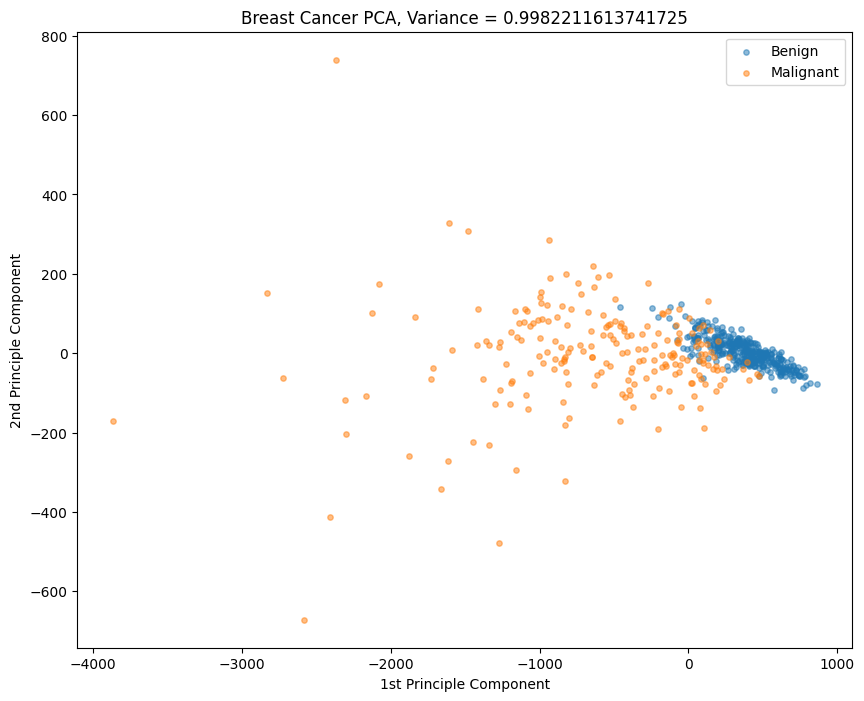

In [69]:
prob1()

## Problem 2
Implement the function similar()

In [70]:
def similar(i, Xhat):
    """
    Takes an index and matrix representing the principal components 
    of a document and returns two indices: the index of the document 
    that is least similar and the index of the document that is most 
    similar to i.
    
    Parameters:
        i: index of a document
        Xhat: decomposed data
    
    Returns:
        index_min: index of the document least similar to document i
        index_max: index of the document most similar to document i
    """
    # Initialize vals
    vals = []
    
    # Loop through the rows of Xhat
    for j in range(Xhat.shape[0]):

        # Compute the cosine similarity between the ith and jth rows
        val = np.dot(Xhat[i], Xhat[j]) / (la.norm(Xhat[i]) * la.norm(Xhat[j]))
        vals.append(val)
    
    # Return the indices of the most and least similar documents
    return np.argsort(vals)[-2], np.argmin(vals)

In [71]:
# Test case
X = np.array([
    [0.78, 0.14, 0.12, 0.  ],
    [0.64, 0.97, 0.  , 0.  ],
    [0.  , 0.  , 0.63, 0.46],
    [0.  , 0.84, 0.6 , 0.  ],
    [0.29, 0.89, 0.51, 0.  ],
    [0.77, 0.  , 0.27, 0.2 ],
    [0.86, 0.47, 0.  , 0.06],
    [0.89, 0.  , 0.  , 0.  ]
]) 
print(similar(4, X))

(3, 7)


### Function for Problem 3

In [111]:
def document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents.
    
    Returns:
        X ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = sorted([folder+p for p in os.listdir(folder) if p.endswith(".txt")])

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r', encoding="utf8") as infile:
            for line in infile:
                vocab.update(extractWords(line)) # Union sets together

    # Load stopwords
    with open("stopwords.txt", 'r',  encoding="utf8") as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # Remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents
    for doc, p in enumerate(paths):
        with open(p, 'r', encoding="utf8") as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, storing counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)
              
    # Create sparse matrix holding these word counts.
    X = sparse.csr_array((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=float)
    return X, paths

## Problem 3
Use the function above and PCA to find speeches most and least similar to a given speech.

In [112]:
def prob3(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 
    principal components to find the most similar and least similar 
    speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    # get X and paths
    X, paths = document_converter()
    
    # perform SVD
    U, E, Vh = sparse.linalg.svds(X, l)
    
    # get Xhat
    X_hat = X @ Vh.T[:, :l]
    
    # get index of speech
    index = paths.index(speech)
    
    # get indices of most and least similar speeches
    maxIndex, minIndex = similar(index, X_hat)
    
    # return speeches
    return paths[maxIndex][12:-4], paths[minIndex][12:-4]

In [113]:
# Run this box once you have written prob3()
speech = './Addresses/1984-Reagan.txt'
print(prob3(speech))

speech = "./Addresses/1993-Clinton.txt"
print(prob3(speech))

('1988-Reagan', '1946-Truman')
('2010-Obama', '1951-Truman')


## Problem 4
Edit the end of the following function to return a weighted sparse matrix A.

In [123]:
def weighted_document_converter():
    """
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
        A ((n x m) sparse matrix): Each row represents a document
        paths (list): list where each element is a speech path 
            eg: path[0] is './Addresses/1990-Bush.txt'
    """
    # Get list of filepaths to each text file in the folder.
    X, paths = document_converter()
    m, n = X.shape
    
    # Convert X to a dense array
    X_dense = X.toarray()
    
    # compute local weights
    p = X_dense / np.sum(X_dense, axis = 0)

    # compute global weights
    g = np.zeros(n)
    for j in range(n):
        g[j] = 1 + np.sum(np.fromiter((p[i, j] * np.log1p(p[i, j]) for i in range(m)), dtype = float)) / np.log(m)

    # compute A
    A = g * np.log1p(X_dense)
    return A, paths

## Problem 5
Use the weighted_document_converter() function above and scikit-learn's PCA to find speeches most and least similar to a given speech.

In [124]:
def prob5(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with 
    the first 7 principal components to find the most similar and least 
    similar speeches.

    Parameters:
        speech (str): Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    # load weighted document matrix
    X_sparse, paths = weighted_document_converter()
    Xhat = TruncatedSVD(n_components = l, random_state = 74).fit_transform(X_sparse)

    # find most and least similar speeches
    most_index, least_index = similar(paths.index(speech), Xhat)
    most_similar = paths[most_index].split('/')[-1].split('.')[0]
    least_similar = paths[least_index].split('/')[-1].split('.')[0]

    # return result
    return most_similar, least_similar

In [125]:
# Run this box after you have completed prob5()
speech = "./Addresses/1993-Clinton.txt"
print(prob5(speech))

speech = './Addresses/1984-Reagan.txt'
print(prob5(speech))

('1992-Bush', '1946-Truman')
('1985-Reagan', '1946-Truman')


## Prob 6

In [126]:
# Load the data
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target # Class labels (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

# Scale the data, fit the model, and predict the labels
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)

# Fit the model, and predict the labels
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)

# Print the classification reports
print(classification_report(y_test, knn_predicted))
print(classification_report(y_test, forest_predicted))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        56
           1       0.94      0.90      0.92        87

    accuracy                           0.90       143
   macro avg       0.89      0.90      0.90       143
weighted avg       0.90      0.90      0.90       143

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        56
           1       0.95      0.95      0.95        87

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



## Prob 7

In [127]:
# Use a pipeline to perform PCA followed by a classifier
rand_forest = RandomForestClassifier()
param_grid = {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10], "max_features": ["sqrt", "log2"]}
grid = GridSearchCV(rand_forest, param_grid, scoring = "f1", n_jobs = -1)

# fit the grid search
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_, "Best Score:", rfc_gs.best_score_, sep = '\n')

# Print the confusion matrices
predicted = grid.best_estimator_.predict(X_test)
CM = confusion_matrix(y_test, predicted)
print("\nConfusion Matrix")
print(CM)

Best Parameters:
{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
Best Score:
0.9725054987251678

Confusion Matrix
[[52  4]
 [ 7 80]]


## Problem 8
- Create a pipeline with a StandardScaler, PCA, and a KNeighborsClassifier
- Do a grid search, modifying at least 6 parameters
- Print your best parameters and best score (f1)
- Get a score of at least 0.96

In [128]:
# Create a pipeline
pipeline = Pipeline([("scaler", StandardScaler()), ("pca", PCA()), ("knn", KNeighborsClassifier())])

# Create a parameter grid
pipeline_parameter_grid = {"scaler__with_mean": [True, False],"scaler__with_std": [True, False],
                   "pca__n_components":[5, 10, None, 'mle'], "pca__whiten":[True, False], 
                   "knn__n_neighbors": [2, 3, 4, 5, 6], "knn__weights": ["uniform", "distance"]}

#find best
pipe_gs = GridSearchCV(pipeline, pipeline_parameter_grid, n_jobs = -1).fit(X_train, y_train)

In [130]:
# Print the best parameters and score
print(pipe_gs.best_params_, pipe_gs.best_score_, sep = '\n')

{'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'pca__n_components': 10, 'pca__whiten': False, 'scaler__with_mean': True, 'scaler__with_std': True}
0.9718467852257182
